In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression 
from l0bnb import fit_path
from sklearn  import model_selection


# Question 8


### Simulate data

In [157]:
X = np.random.normal(loc=0, scale=1, size=100)
noise = np.random.normal(size=100)

B_0 = 2
B_1 = -3
B_2 = 6
B_3 = -4

y = B_0 + B_1 * X + B_2 * X**2 + B_3 * X**3 + noise

### Perform forward stepwise selection


In [158]:
# Preprocessing
X = np.column_stack([X**i for i in range(1, 11)])
X = pd.DataFrame(X, columns=[f"X^{i}" for i in range(1, 11)])
y = pd.Series(y)

# Estimate sigma2
full_model = linear_model.LinearRegression()
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
residuals = y - y_pred_full
sigma2 = MSE(y, y_pred_full)


# Create scorer
def nCp(sigma2, estimator, X, y):
    """Mallows' Cp statistic."""
    n, p = X.shape
    y_pred = estimator.predict(X)
    RSS = np.sum((y - y_pred) ** 2)
    return -(RSS + 2 * p * sigma2) / n


Cp = partial(nCp, sigma2)

In [159]:
# Perform forward stepwise selection
stepwise_forward = SequentialFeatureSelector(
    linear_model.LinearRegression(),
    n_features_to_select="auto",
    direction="forward",
    scoring=Cp,
)
stepwise_forward.fit(X, y)
selected_features = X.columns[stepwise_forward.get_support()]

# Fit the model with selected features
model_selected = linear_model.LinearRegression().fit(
    X[selected_features], y
)

# Report the coefficients
coefficients = model_selected.coef_
intercept = model_selected.intercept_
print(f"Selected features: {selected_features.tolist()}")
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Selected features: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5']
Coefficients: [-2.72931465  6.21105897 -3.91007843 -0.0344736  -0.02165969]
Intercept: 1.817372031749871


### Backward Selection 

In [160]:
# Perform backward stepwise selection
stepwise_backward = SequentialFeatureSelector(
    linear_model.LinearRegression(),
    n_features_to_select="auto",
    direction="backward",
    scoring=Cp,
)
stepwise_backward.fit(X, y)
selected_features = X.columns[stepwise_backward.get_support()]

# Fit the model with selected features
model_selected = linear_model.LinearRegression().fit(
    X[selected_features], y
)

# Report the coefficients
coefficients = model_selected.coef_
intercept = model_selected.intercept_
print(f"Selected features: {selected_features.tolist()}")
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Selected features: ['X^1', 'X^2', 'X^3', 'X^5', 'X^8']
Coefficients: [-2.77910892e+00  6.09854854e+00 -3.84395178e+00 -3.77656368e-02
  3.16841162e-05]
Intercept: 1.8515276833317227


### Lasso

Optimal Alpha (λ): 6.445020227928846
Coefficient Estimates: [-0.          0.         -0.          0.         -1.02031311  0.16292944
 -0.09406184  0.08243977  0.         -0.00478209]


/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.134522785692297, tolerance: 1.4366825620235486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330.0672052097709, tolerance: 1.4366825620235486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.97526655114552, tolerance: 1.3833258917384026
  model = cd_fast.enet_coordinate_descent_gram(
/Users/fi

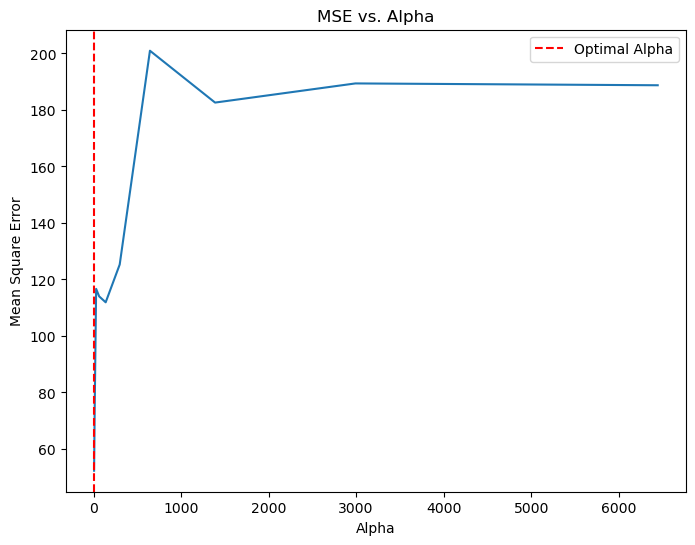

In [161]:
# Fit a lasso model using cross-validation to select the optimal lambda
lasso_cv = linear_model.LassoCV(cv=5, n_alphas=10).fit(X, y)

# Plot the mean square error for each alpha
plt.figure(figsize=(8, 6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1))
plt.xlabel('Alpha')
plt.ylabel('Mean Square Error')
plt.title('MSE vs. Alpha')
plt.axvline(lasso_cv.alpha_, color='r', linestyle='--', label='Optimal Alpha')
plt.legend()

# Report the resulting coefficient estimates
print(f"Optimal Alpha (λ): {lasso_cv.alpha_}")
print(f"Coefficient Estimates: {lasso_cv.coef_}")

# Question 9

### Split the data into test and train

In [162]:
# Get data
df = pd.DataFrame(load_data("College"))
# Convert "Private" column to numerical values
df["Private"] = df["Private"].astype("category").cat.codes

y = df["Apps"]
X = df.drop(columns="Apps")

# Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.33)

### fit OLS

In [163]:
# Find features
sfs = SequentialFeatureSelector(
    linear_model.LinearRegression(),
    n_features_to_select="auto",
    direction="forward",
    scoring=Cp,
)

sfs.fit(X_train, y_train)

features_selected = sfs.get_support()

# Create model
ols_model = linear_model.LinearRegression().fit(X_train.loc[:, features_selected], y_train)

predicts = ols_model.predict(X_test.loc[:, features_selected])
error_ols = MSE(y_test, predicts)
print(f"Mean Squared Error: {error_ols}")

Mean Squared Error: 1348459.7244137845


### Ridge regression

In [164]:
# Find features
ridge = linear_model.RidgeCV(cv=5)
ridge.fit(X_train, y_train)
support = ridge.coef_ != 0

# Create model
ridge_model = linear_model.LinearRegression().fit(X_train.loc[:, support], y_train)

predicts = ridge_model.predict(X_test.loc[:, support])
error_ridge = MSE(y_test, predicts)
print(f"Mean Squared Error: {error_ridge}")

Mean Squared Error: 1240634.4751659543


### Lasso

In [165]:
# Fit lasso with K-fold cv
lasso = linear_model.LassoCV(cv=5)
lasso.fit(X_train, y_train)
support = lasso.coef_ != 0

# Create model
lasso_model = linear_model.LinearRegression().fit(X_train.loc[:, support], y_train)

# Error
predicts = lasso_model.predict(X_test.loc[:, support])
error_lasso = MSE(y_test, predicts)
print(f"Mean Squared Error: {error_lasso}")

Mean Squared Error: 1527247.266547843


### PCR

In [166]:
# Apply principal component analysis
pca = PCA()
linreg = linear_model.LinearRegression()
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("linreg", linreg)])
pipe.fit(X_train, y_train)

# CV
param_grid = {"pca__n_components": range(1, 20)}
grid = model_selection.GridSearchCV(pipe, param_grid, cv=model_selection.KFold(), scoring="neg_mean_squared_error")
grid.fit(X_train, y_train)

/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/pip

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

In [196]:
# Error
predicts = grid.predict(X_test)
error_PCR = MSE(y_test, predicts)
print(f"Mean Squared Error: {error_PCR}")
print(f"Best number of components: {grid.best_estimator_}")

Mean Squared Error: 1337654.6211182545
Best number of components: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=16)),
                ('linreg', LinearRegression())])


### PLS

In [201]:
# Partial least squares
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X_train, y_train)

# CV
param_grid = {"n_components": range(1, 20)}
grid = model_selection.GridSearchCV(
    pls, param_grid, cv=model_selection.KFold(), scoring="neg_mean_squared_error"
)
grid.fit(X_train, y_train)

Mean Squared Error: 1232937.0799825755
Best number of components: PLSRegression(n_components=9)


/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py", line 649, in fit
    super().fit(X, Y)
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/base.py", line 1

In [202]:
# Error
predicts = grid.predict(X_test)
error_PLS = MSE(y_test, predicts)
print(f"Mean Squared Error: {error_PLS}")
print(f"Best number of components: {grid.best_estimator_}")

Mean Squared Error: 1232937.0799825755
Best number of components: PLSRegression(n_components=9)


In [203]:
errors = {"PLS": error_PLS, "PCR": error_PCR, "Lasso": error_lasso, "Ridge": error_ridge, "OLS": error_ols}
min_error_name = min(errors, key=errors.get)
print(f"Smallest error is {min_error_name} with a value of {errors[min_error_name]}")

Smallest error is PLS with a value of 1232937.0799825755
